In [1]:
########################################
# Activity Prediction by Deep Learning #
# @author: A.Prof. Tran Van Lang, PhD  #
# File: usingKeras_notMMS.py                  #
########################################

import numpy as np
import pandas as pd
import csv
from time import time
from keras.models import Sequential
from keras.layers import Dense, Dropout
#from keras.optimizers import Adam
from keras.optimizers.legacy import Adam
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE,ADASYN,BorderlineSMOTE
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from visualLang import visualization_proba

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
# Để không xuất lỗi warning của TensorFlow: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
path = 'data/BioassayDatasets/AID373red'
df_train = pd.read_csv( path + '_train.csv')
df_test  = pd.read_csv( path + '_test.csv' )

# Delete the missing values datapoint
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

# Split the dataset into features and labels
X_tr = df_train.drop('Outcome', axis=1)
X_te = df_test.drop('Outcome', axis=1)

y_tr = df_train['Outcome']
y_te = df_test['Outcome']

# Convert the features and labels to NumPy arrays
X_train = np.array(X_tr)
y_train = np.array(y_tr)

X_test = np.array(X_te)
y_test = np.array(y_te)

y_train = np.where(y_train == 'Active', 0, 1)
y_test = np.where(y_test == 'Active', 0, 1)

results = []

In [3]:
################ HUẤN LUYỆN MÔ HÌNH ################

In [4]:
def modelLang(X_train, learning_rate, dropout_rate):
    dropout_rate = 0.3
    learning_rate = 0.0001
    optimizer = Adam(learning_rate=learning_rate)

    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [5]:
def objectiveFunc(learning_rate, dropout_rate):
    model = modelLang(X_train,learning_rate, dropout_rate)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [6]:
def trainLang(X_train,y_train,learning_rate=0.0001,dropout_rate=0.1):
    t0 = time()
    model = modelLang( X_train,learning_rate, dropout_rate ) 
    model.fit(X_train, y_train, epochs=100, verbose=0)
    print( 'Eslaped time: %5.2f seconds' %(time()-t0) )
    return model

def trainBOLang(X_train,y_train):
    t0 = time()
    params = {'learning_rate':(0.0001,0.1),'dropout_rate':(0.1,0.5)}
    optimizer = BayesianOptimization(f=objectiveFunc, pbounds=params)
    optimizer.maximize(init_points=5,n_iter=10)

    # Tìm được các tham số tối ưu để xây dựng mô hình
    opt_learning_rate = optimizer.max['params']['learning_rate']
    opt_dropout_rate = optimizer.max['params']['dropout_rate']

    model = modelLang(X_train,opt_learning_rate, opt_dropout_rate)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    print( 'Eslaped time: %5.2f seconds' %(time()-t0) )
    return model

def resampleBOLang(estimator,X_train,y_train,X_test,y_test):
    print("Số lượng mẫu sau khi resample để huấn luyện:", len(X_train))
    model = trainBOLang(X_train,y_train)
    estimator,metric,npred = visualization_proba(estimator+str(len(X_train)),model,X_test,y_test)
    return estimator,metric,npred

Số lượng mẫu dùng huấn luyện: 47831
Eslaped time: 50.48 seconds
374/374 [==============================] - 0s 209us/step

               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       1.00      1.00      1.00     11945

    accuracy                           1.00     11957
   macro avg       0.50      0.50      0.50     11957
weighted avg       1.00      1.00      1.00     11957

Loss: 0.009490950964391232
Accuracy: 0.998996376991272
AUC: 0.7860925073252407


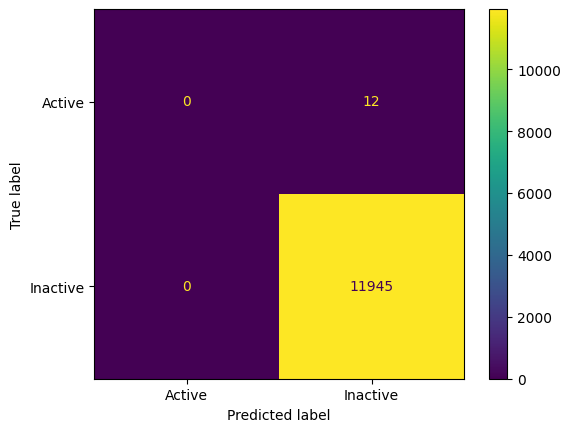

In [7]:
print("Số lượng mẫu dùng huấn luyện:", len(X_train))
model = trainLang(X_train,y_train)

estimator,metric,npred = visualization_proba('DeepLearning_'+str(len(X_train)),model,X_test,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu dùng huấn luyện: 47831
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 211us/step
| 1         | 0.999     | 0.2726    | 0.08365   |
374/374 [==============================] - 0s 211us/step
| 2         | 0.999     | 0.4188    | 0.06061   |
374/374 [==============================] - 0s 209us/step
| 3         | 0.999     | 0.2162    | 0.01849   |
374/374 [==============================] - 0s 207us/step
| 4         | 0.999     | 0.2911    | 0.09129   |
374/374 [==============================] - 0s 208us/step
| 5         | 0.999     | 0.101     | 0.08733   |
374/374 [==============================] - 0s 207us/step
| 6         | 0.999     | 0.4994    | 0.0002963 |
374/374 [==============================] - 0s 208us/step
| 7         | 0.999     | 0.4999    | 0.001552  |
374/374 [==============================] - 0s 209us/step
| 8         | 0.999     | 0.1923    | 0.06061   |
374/374 

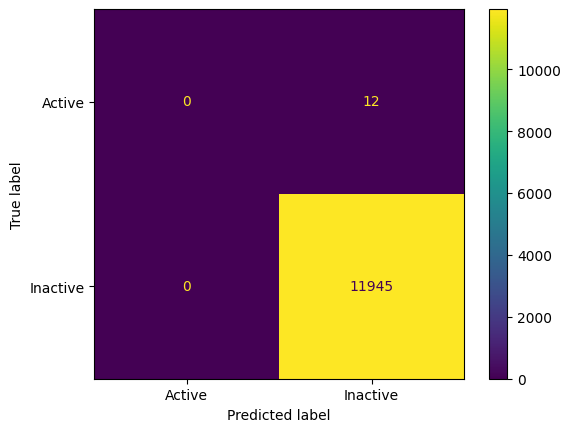

In [8]:
print("Số lượng mẫu dùng huấn luyện:", len(X_train))
model = trainBOLang(X_train,y_train)

estimator,metric,npred = visualization_proba('DeepLearning, BO_'+str(len(X_train)),model,X_test,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

In [9]:
################## BỎ XỬ LÝ DỮ LIỆU DÙNG MIN-MAX SCALING ###############

In [10]:
X_train_mms = X_train
X_test_mms = X_test

Số lượng mẫu dùng huấn luyện: 47831
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 209us/step
| 1         | 0.999     | 0.2911    | 0.09117   |
374/374 [==============================] - 0s 217us/step
| 2         | 0.999     | 0.2571    | 0.08826   |
374/374 [==============================] - 0s 209us/step
| 3         | 0.999     | 0.2522    | 0.0504    |
374/374 [==============================] - 0s 209us/step
| 4         | 0.999     | 0.3823    | 0.08158   |
374/374 [==============================] - 0s 209us/step
| 5         | 0.999     | 0.223     | 0.0635    |
374/374 [==============================] - 0s 210us/step
| 6         | 0.999     | 0.4995    | 0.0009826 |
374/374 [==============================] - 0s 211us/step
| 7         | 0.999     | 0.101     | 0.0001881 |
374/374 [==============================] - 0s 205us/step
| 8         | 0.999     | 0.1897    | 0.05253   |
374/374 

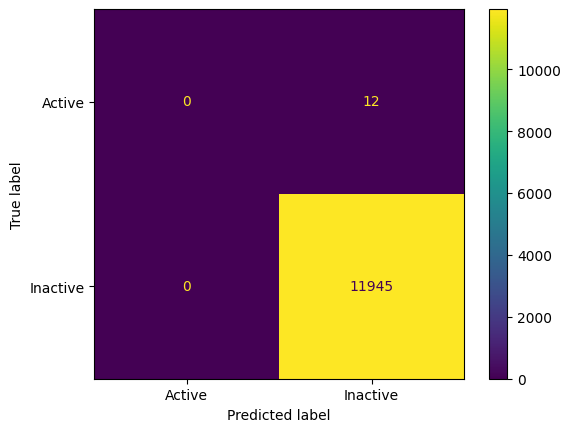

In [11]:
print("Số lượng mẫu dùng huấn luyện:", len(X_train_mms))
model = trainBOLang(X_train_mms,y_train)

estimator,metric,npred = visualization_proba('DeepLearning, BO_'+str(len(X_train_mms)),model,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

In [12]:
################# RESAMPLING ###################

Số lượng mẫu sau khi resample để huấn luyện: 95562
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 208us/step
| 1         | 0.999     | 0.3435    | 0.05408   |
374/374 [==============================] - 0s 207us/step
| 2         | 0.999     | 0.1875    | 0.01777   |
374/374 [==============================] - 0s 207us/step
| 3         | 0.999     | 0.4931    | 0.08301   |
374/374 [==============================] - 0s 209us/step
| 4         | 0.999     | 0.3683    | 0.01628   |
374/374 [==============================] - 0s 208us/step
| 5         | 0.999     | 0.445     | 0.08203   |
374/374 [==============================] - 0s 209us/step
| 6         | 0.999     | 0.1005    | 0.09985   |
374/374 [==============================] - 0s 208us/step
| 7         | 0.999     | 0.1       | 0.001276  |
374/374 [==============================] - 0s 208us/step
| 8         | 0.999     | 0.4551    | 0.051

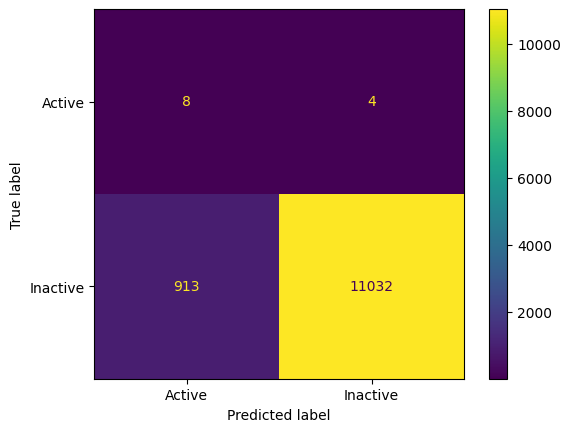

In [13]:
# Sử dụng SMOTE để tăng cường dữ liệu thiểu số
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_mms,y_train)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, SMOTE_',X_train_smote,y_train_smote,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95572
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 209us/step
| 1         | 0.999     | 0.4618    | 0.05387   |
374/374 [==============================] - 0s 210us/step
| 2         | 0.999     | 0.1054    | 0.04738   |
374/374 [==============================] - 0s 207us/step
| 3         | 0.999     | 0.4062    | 0.04898   |
374/374 [==============================] - 0s 208us/step
| 4         | 0.999     | 0.4492    | 0.04998   |
374/374 [==============================] - 0s 206us/step
| 5         | 0.999     | 0.3907    | 0.006763  |
374/374 [==============================] - 0s 203us/step
| 6         | 0.999     | 0.1002    | 0.09824   |
374/374 [==============================] - 0s 207us/step
| 7         | 0.999     | 0.1006    | 0.002425  |
374/374 [==============================] - 0s 207us/step
| 8         | 0.999     | 0.1107    | 0.052

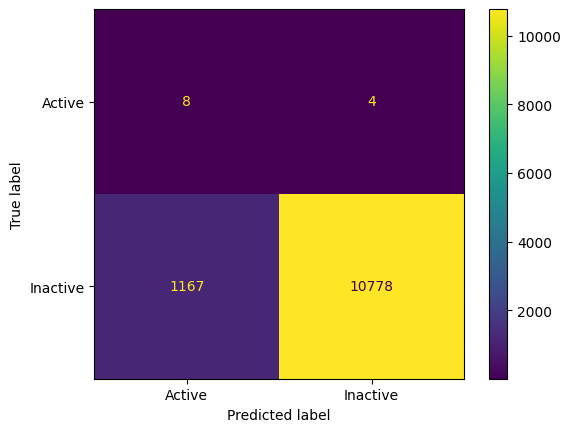

In [14]:
# Sử dụng ADASYN để tăng cường dữ liệu thiểu số
adasyn = ADASYN()
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_mms,y_train)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, ADASYN_',X_train_adasyn,y_train_adasyn,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95562
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 211us/step
| 1         | 0.999     | 0.3174    | 0.07711   |
374/374 [==============================] - 0s 204us/step
| 2         | 0.999     | 0.4494    | 0.03157   |
374/374 [==============================] - 0s 207us/step
| 3         | 0.999     | 0.2173    | 0.09908   |
374/374 [==============================] - 0s 207us/step
| 4         | 0.999     | 0.4329    | 0.09165   |
374/374 [==============================] - 0s 207us/step
| 5         | 0.999     | 0.2957    | 0.09034   |
374/374 [==============================] - 0s 206us/step
| 6         | 0.999     | 0.1002    | 0.004184  |
374/374 [==============================] - 0s 208us/step
| 7         | 0.999     | 0.1012    | 0.0002915 |
374/374 [==============================] - 0s 207us/step
| 8         | 0.999     | 0.4557    | 0.001

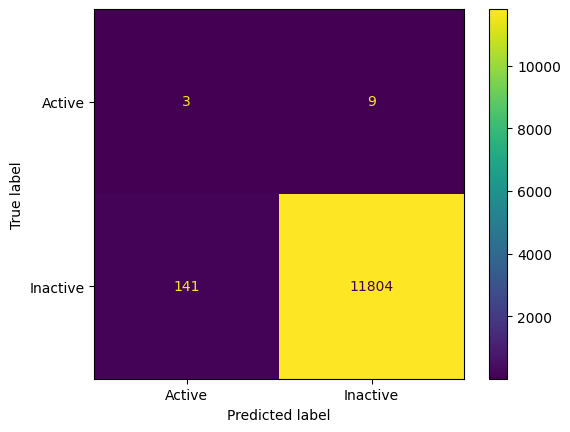

In [15]:
# Sử dụng Borderline-SMOTE để tăng cường dữ liệu thiểu số
borderline_smote = BorderlineSMOTE()
X_train_borderline, y_train_borderline = borderline_smote.fit_resample(X_train_mms,y_train)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, BorderlineSMOTE_',X_train_borderline,y_train_borderline,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 93359
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 206us/step
| 1         | 0.999     | 0.3852    | 0.02993   |
374/374 [==============================] - 0s 210us/step
| 2         | 0.999     | 0.1727    | 0.09909   |
374/374 [==============================] - 0s 208us/step
| 3         | 0.999     | 0.1723    | 0.02501   |
374/374 [==============================] - 0s 207us/step
| 4         | 0.999     | 0.4766    | 0.04565   |
374/374 [==============================] - 0s 208us/step
| 5         | 0.999     | 0.2646    | 0.02044   |
374/374 [==============================] - 0s 207us/step
| 6         | 0.999     | 0.4991    | 0.09863   |
374/374 [==============================] - 0s 209us/step
| 7         | 0.999     | 0.1005    | 0.0005439 |
374/374 [==============================] - 0s 208us/step
| 8         | 0.999     | 0.2701    | 0.098

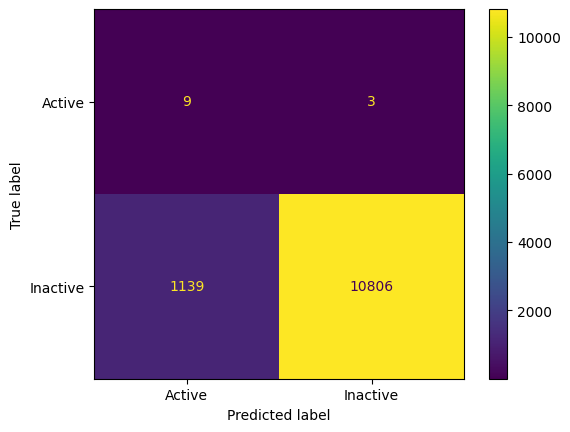

In [16]:
# Sử dụng SMOTE-ENN để kết hợp SMOTE và Edited Nearest Neighbors
smote_enn = SMOTEENN()
X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train_mms, y_train)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, SMOTEENN_',X_train_smoteenn,y_train_smoteenn,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95562
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 208us/step
| 1         | 0.999     | 0.4479    | 0.02109   |
374/374 [==============================] - 0s 208us/step
| 2         | 0.999     | 0.1909    | 0.07444   |
374/374 [==============================] - 0s 209us/step
| 3         | 0.999     | 0.3214    | 0.05275   |
374/374 [==============================] - 0s 208us/step
| 4         | 0.999     | 0.4175    | 0.0552    |
374/374 [==============================] - 0s 215us/step
| 5         | 0.999     | 0.2095    | 0.07459   |
374/374 [==============================] - 0s 207us/step
| 6         | 0.999     | 0.1006    | 0.0007277 |
374/374 [==============================] - 0s 206us/step
| 7         | 0.999     | 0.4998    | 0.09893   |
374/374 [==============================] - 0s 206us/step
| 8         | 0.999     | 0.3355    | 0.004

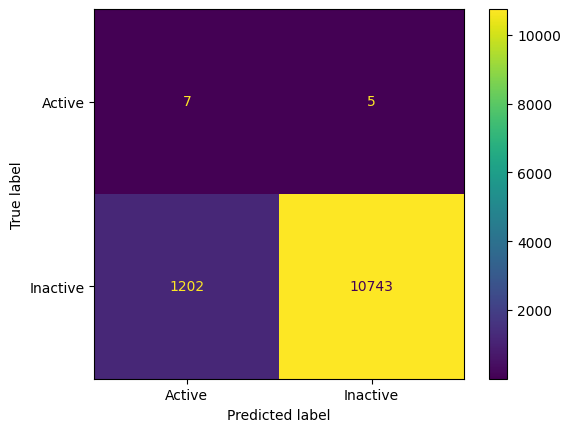

In [17]:
# Sử dụng Random Oversampling để tăng cường dữ liệu thiểu số
random_oversampler = RandomOverSampler()
X_train_random, y_train_random = random_oversampler.fit_resample(X_train_mms, y_train)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, RandomOverSamples_',X_train_random,y_train_random,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 100
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 208us/step
| 1         | 0.999     | 0.1201    | 0.05785   |
374/374 [==============================] - 0s 207us/step
| 2         | 0.999     | 0.3329    | 0.05735   |
374/374 [==============================] - 0s 216us/step
| 3         | 0.999     | 0.1232    | 0.04112   |
374/374 [==============================] - 0s 207us/step
| 4         | 0.999     | 0.1192    | 0.07394   |
374/374 [==============================] - 0s 210us/step
| 5         | 0.999     | 0.4684    | 0.02239   |
374/374 [==============================] - 0s 208us/step
| 6         | 0.999     | 0.4994    | 0.002341  |
374/374 [==============================] - 0s 209us/step
| 7         | 0.999     | 0.4997    | 0.09614   |
374/374 [==============================] - 0s 207us/step
| 8         | 0.999     | 0.2733    | 0.08196

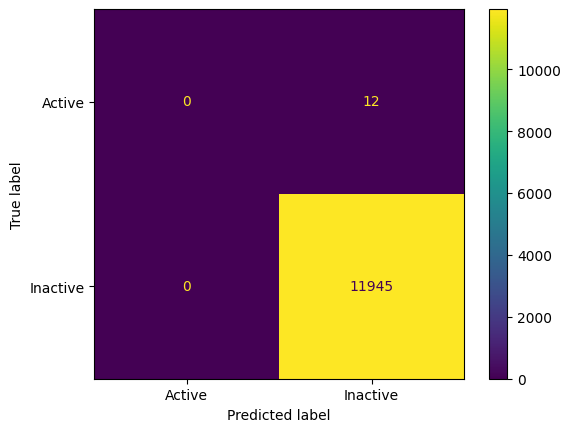

In [18]:
# Sử dụng Random Undersampling để giảm dữ liệu đa số
random_undersampler = RandomUnderSampler()
X_train_random, y_train_random = random_undersampler.fit_resample(X_train_mms, y_train)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, RandomUnderSamples_',X_train_random,y_train_random,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95562
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 208us/step
| 1         | 0.999     | 0.2481    | 0.05276   |
374/374 [==============================] - 0s 207us/step
| 2         | 0.999     | 0.3517    | 0.006318  |
374/374 [==============================] - 0s 208us/step
| 3         | 0.999     | 0.2448    | 0.09876   |
374/374 [==============================] - 0s 208us/step
| 4         | 0.999     | 0.3046    | 0.05703   |
374/374 [==============================] - 0s 208us/step
| 5         | 0.999     | 0.3599    | 0.00306   |
374/374 [==============================] - 0s 207us/step
| 6         | 0.999     | 0.1002    | 0.09725   |
374/374 [==============================] - 0s 208us/step
| 7         | 0.999     | 0.4994    | 0.003648  |
374/374 [==============================] - 0s 209us/step
| 8         | 0.999     | 0.4298    | 0.054

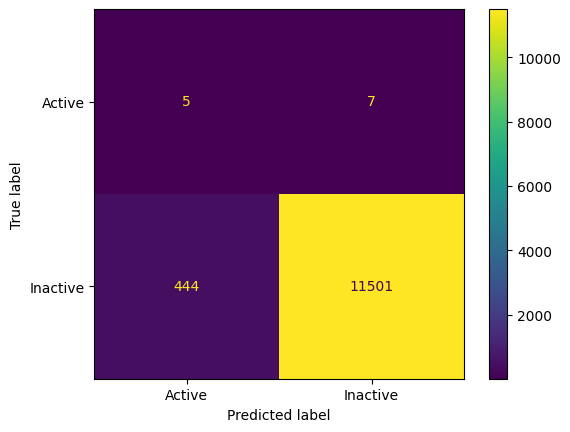

In [19]:
# Áp dụng phương pháp SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train_mms, y_train)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, SMOTETomek_',X_train_smotetomek,y_train_smotetomek,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

In [20]:
############### DÙNG KỸ THUẬT GAN ####################

In [21]:
def augmentLang( X_train, y_train, batch_size=32, epochs=50 ):
    # Số lượng nhãn thiểu số và đa số
    count_minority = np.sum(y_train == 0)
    count_majority = np.sum(y_train == 1)
    dim = X_train.shape[1]

    # Tạo mô hình GAN
    generator = Sequential()
    generator.add(Dense(32, input_dim=dim, activation='relu'))
    generator.add(Dense(dim, activation='sigmoid'))
    generator.compile(loss='binary_crossentropy', optimizer=Adam())

    discriminator = Sequential()
    discriminator.add(Dense(32, input_dim=dim, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(Dense(1, activation='sigmoid', kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    gan = Sequential()
    gan.add(generator)
    gan.add(discriminator)
    gan.compile(loss='binary_crossentropy', optimizer=Adam())

    # Huấn luyện GAN
    for epoch in range(epochs):
        # Tạo mẫu dữ liệu giả tạo
        random_noise = np.random.normal(0, 1, size=[count_minority,dim])
        generated_data = generator.predict(random_noise)

        # Kết hợp dữ liệu thật và giả tạo
        X_combined = np.concatenate([X_train, generated_data])
        y_combined = np.concatenate([y_train, np.zeros(count_minority)])

        # Huấn luyện bộ phân biệt
        discriminator.trainable = True
        discriminator.fit(X_combined, y_combined, batch_size=batch_size, epochs=1, verbose=0)

        # Huấn luyện bộ sinh
        discriminator.trainable = False
        gan.fit(random_noise, np.ones(count_minority), batch_size=batch_size, epochs=1, verbose=0)
    
    # Tạo dữ liệu mới từ bộ sinh đã đào tạo
    random_noise = np.random.normal(0, 1, size=[count_minority, X_train.shape[1]])
    generated_data = generator.predict(random_noise)

    # Kết hợp dữ liệu mới và gốc
    X_augmented = np.concatenate([X_train, generated_data])
    y_augmented = np.concatenate([y_train, np.zeros(count_minority)])
    return X_augmented, y_augmented

In [22]:
from tensorflow.keras import initializers

print( 'Số mẫu của 2 nhãn là: ',np.sum(y_train==0),np.sum(y_train==1) )
X_train_gan, y_train_gan = augmentLang( X_train_mms, y_train )

Số mẫu của 2 nhãn là:  50 47781
2/2 [==============================] - 0s 827us/step


Eslaped time: 50.46 seconds
374/374 [==============================] - 0s 209us/step

               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       1.00      1.00      1.00     11945

    accuracy                           1.00     11957
   macro avg       0.50      0.50      0.50     11957
weighted avg       1.00      1.00      1.00     11957

Loss: 0.00837793480604887
Accuracy: 0.998996376991272
AUC: 0.7841844565369052


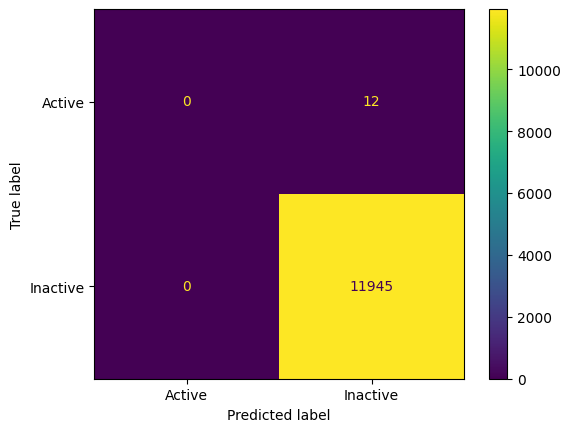

In [23]:
model = trainLang(X_train_gan, y_train_gan)
estimator,metric,npred = visualization_proba('DeepLearning, GAN_'+str(len(X_train_gan)),model,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95562
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 211us/step
| 1         | 0.999     | 0.4984    | 0.06483   |
374/374 [==============================] - 0s 209us/step
| 2         | 0.999     | 0.4353    | 0.06748   |
374/374 [==============================] - 0s 212us/step
| 3         | 0.999     | 0.3745    | 0.09946   |
374/374 [==============================] - 0s 207us/step
| 4         | 0.999     | 0.4829    | 0.01097   |
374/374 [==============================] - 0s 209us/step
| 5         | 0.999     | 0.4       | 0.005267  |
374/374 [==============================] - 0s 208us/step
| 6         | 0.999     | 0.1001    | 0.003461  |
374/374 [==============================] - 0s 208us/step
| 7         | 0.999     | 0.1004    | 0.0979    |
374/374 [==============================] - 0s 208us/step
| 8         | 0.999     | 0.3572    | 0.072

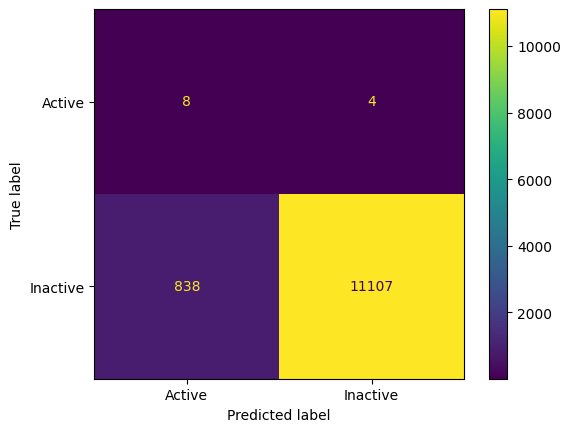

In [24]:
# Sử dụng SMOTE để tăng cường dữ liệu thiểu số
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_gan,y_train_gan)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, GAN, SMOTE_',X_train_smote,y_train_smote,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95562
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 209us/step
| 1         | 0.999     | 0.1999    | 0.07516   |
374/374 [==============================] - 0s 216us/step
| 2         | 0.999     | 0.4524    | 0.007535  |
374/374 [==============================] - 0s 211us/step
| 3         | 0.999     | 0.2896    | 0.0424    |
374/374 [==============================] - 0s 209us/step
| 4         | 0.999     | 0.1504    | 0.05911   |
374/374 [==============================] - 0s 208us/step
| 5         | 0.999     | 0.4865    | 0.09142   |
374/374 [==============================] - 0s 208us/step
| 6         | 0.999     | 0.101     | 0.003348  |
374/374 [==============================] - 0s 207us/step
| 7         | 0.999     | 0.4998    | 0.09972   |
374/374 [==============================] - 0s 216us/step
| 8         | 0.999     | 0.2939    | 0.030

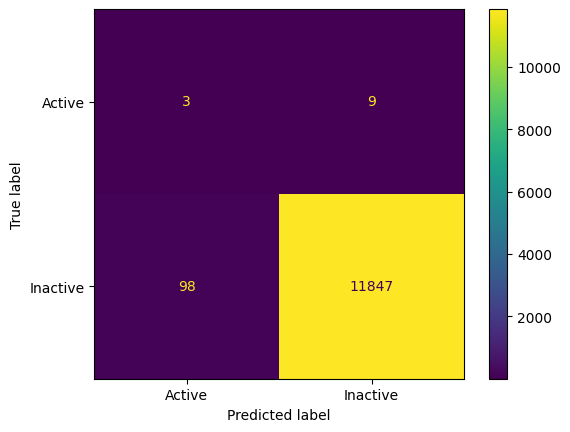

In [25]:
# Sử dụng Borderline-SMOTE để tăng cường dữ liệu thiểu số
borderline_smote = BorderlineSMOTE()
X_train_borderline, y_train_borderline = borderline_smote.fit_resample(X_train_gan,y_train_gan)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, GAN, BorderlineSMOTE_',X_train_borderline,y_train_borderline,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 93368
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 217us/step
| 1         | 0.999     | 0.2831    | 0.03453   |
374/374 [==============================] - 0s 218us/step
| 2         | 0.999     | 0.1308    | 0.09655   |
374/374 [==============================] - 0s 230us/step
| 3         | 0.999     | 0.2882    | 0.02854   |
374/374 [==============================] - 0s 221us/step
| 4         | 0.999     | 0.4201    | 0.07325   |
374/374 [==============================] - 0s 221us/step
| 5         | 0.999     | 0.2517    | 0.04336   |
374/374 [==============================] - 0s 219us/step
| 6         | 0.999     | 0.4984    | 0.002735  |
374/374 [==============================] - 0s 248us/step
| 7         | 0.999     | 0.1       | 0.0004646 |
374/374 [==============================] - 0s 219us/step
| 8         | 0.999     | 0.1557    | 0.035

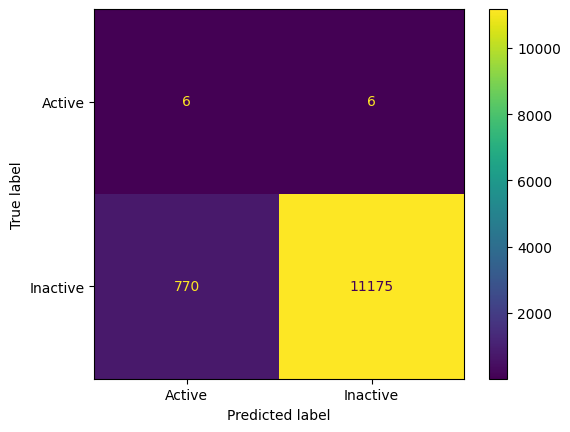

In [26]:
# Sử dụng SMOTE-ENN để kết hợp SMOTE và Edited Nearest Neighbors
smote_enn = SMOTEENN()
X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train_gan, y_train_gan)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, GAN, SMOTEENN_',X_train_smoteenn,y_train_smoteenn,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95562
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 221us/step
| 1         | 0.999     | 0.4075    | 0.07842   |
374/374 [==============================] - 0s 211us/step
| 2         | 0.999     | 0.2769    | 0.03985   |
374/374 [==============================] - 0s 204us/step
| 3         | 0.999     | 0.1968    | 0.07347   |
374/374 [==============================] - 0s 211us/step
| 4         | 0.999     | 0.3107    | 0.08795   |
374/374 [==============================] - 0s 205us/step
| 5         | 0.999     | 0.1041    | 0.0812    |
374/374 [==============================] - 0s 206us/step
| 6         | 0.999     | 0.4994    | 0.002676  |
374/374 [==============================] - 0s 204us/step
| 7         | 0.999     | 0.4985    | 0.004397  |
374/374 [==============================] - 0s 205us/step
| 8         | 0.999     | 0.3466    | 0.028

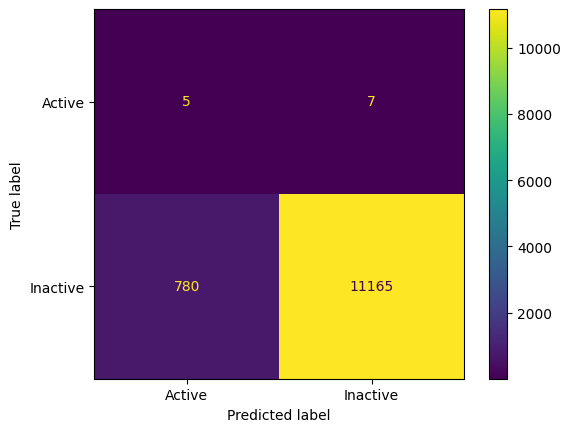

In [27]:
# Sử dụng Random Oversampling để tăng cường dữ liệu thiểu số
random_oversampler = RandomOverSampler()
X_train_random, y_train_random = random_oversampler.fit_resample(X_train_gan, y_train_gan)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, GAN, RandomOverSamples_',X_train_random,y_train_random,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 200
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 213us/step
| 1         | 0.999     | 0.3565    | 0.05011   |
374/374 [==============================] - 0s 207us/step
| 2         | 0.999     | 0.2352    | 0.05829   |
374/374 [==============================] - 0s 210us/step
| 3         | 0.999     | 0.4191    | 0.06495   |
374/374 [==============================] - 0s 215us/step
| 4         | 0.999     | 0.3671    | 0.004714  |
374/374 [==============================] - 0s 210us/step
| 5         | 0.999     | 0.2589    | 0.05243   |
374/374 [==============================] - 0s 208us/step
| 6         | 0.999     | 0.1002    | 0.09597   |
374/374 [==============================] - 0s 208us/step
| 7         | 0.999     | 0.5       | 0.0001662 |
374/374 [==============================] - 0s 207us/step
| 8         | 0.999     | 0.1172    | 0.05128

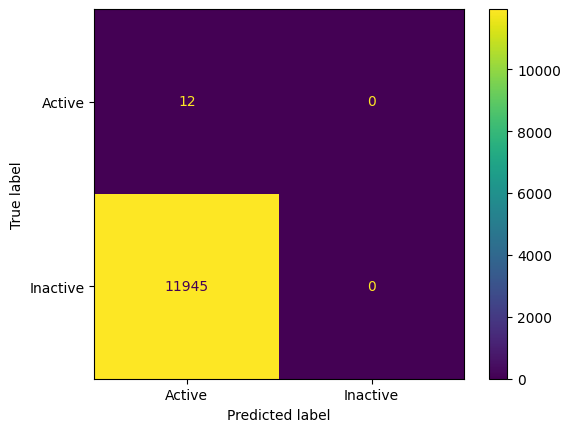

In [28]:
# Sử dụng Random Undersampling để giảm dữ liệu đa số
random_undersampler = RandomUnderSampler()
X_train_random, y_train_random = random_undersampler.fit_resample(X_train_gan, y_train_gan)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, GAN, RandomUnderSamples_',X_train_random,y_train_random,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95560
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 205us/step
| 1         | 0.999     | 0.4647    | 0.09097   |
374/374 [==============================] - 0s 226us/step
| 2         | 0.999     | 0.4664    | 0.0165    |
374/374 [==============================] - 0s 211us/step
| 3         | 0.999     | 0.265     | 0.03184   |
374/374 [==============================] - 0s 213us/step
| 4         | 0.999     | 0.4623    | 0.07897   |
374/374 [==============================] - 0s 209us/step
| 5         | 0.999     | 0.2416    | 0.07077   |
374/374 [==============================] - 0s 211us/step
| 6         | 0.999     | 0.1004    | 0.006251  |
374/374 [==============================] - 0s 209us/step
| 7         | 0.999     | 0.1002    | 0.09548   |
374/374 [==============================] - 0s 211us/step
| 8         | 0.999     | 0.1962    | 0.001

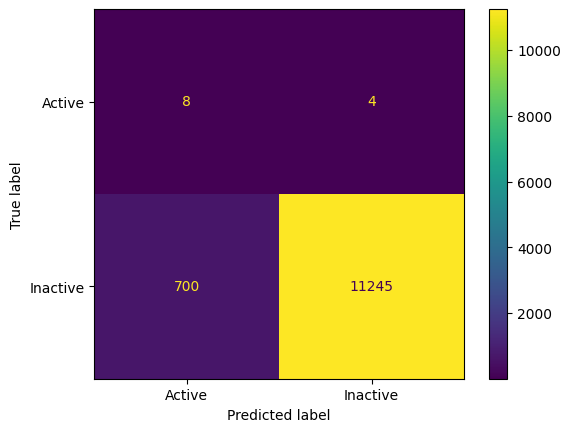

In [29]:
# Áp dụng phương pháp SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train_gan, y_train_gan)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, GAN, SMOTETomek_',X_train_smotetomek,y_train_smotetomek,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95572
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 203us/step
| 1         | 0.999     | 0.4796    | 0.09076   |
374/374 [==============================] - 0s 209us/step
| 2         | 0.999     | 0.3319    | 0.08472   |
374/374 [==============================] - 0s 209us/step
| 3         | 0.999     | 0.1197    | 0.07504   |
374/374 [==============================] - 0s 209us/step
| 4         | 0.999     | 0.3526    | 0.04402   |
374/374 [==============================] - 0s 207us/step
| 5         | 0.999     | 0.4924    | 0.04613   |
374/374 [==============================] - 0s 208us/step
| 6         | 0.999     | 0.1004    | 0.002664  |
374/374 [==============================] - 0s 214us/step
| 7         | 0.999     | 0.1004    | 0.001427  |
374/374 [==============================] - 0s 209us/step
| 8         | 0.999     | 0.3507    | 0.013

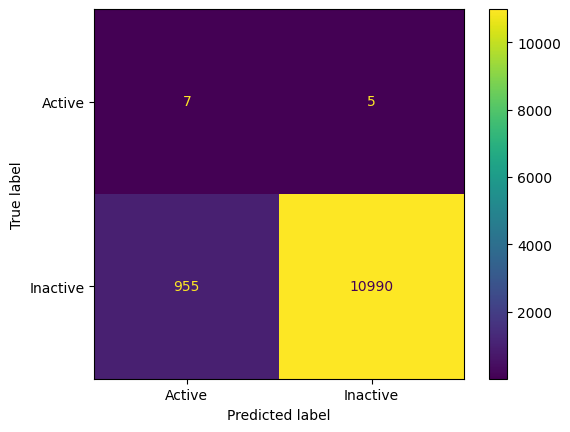

In [30]:
# Sử dụng ADASYN để tăng cường dữ liệu thiểu số
adasyn = ADASYN()
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_gan,y_train_gan)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, GAN, ADASYN_',X_train_adasyn,y_train_adasyn,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

In [31]:
filename = os.path.basename(path) + '_Keras_NotMMS'
with open(filename + '.csv', "w") as file:
    writer = csv.writer(file, delimiter=",")
    writer.writerow(['Phương pháp tiếp cận','Precision','G-mean','AUC','Accuracy','Recall','F1-score','Active: Đoán đúng','Active: Đoán nhầm','Inactive: Đoán đúng','Inactive: Đoán nhầm'])
    for row in results:
        writer.writerow(row)
file.close()

df = pd.read_csv(filename + '.csv')
df.to_excel(filename + '.xlsx', index=False)